## This notebook looks into the data and explore ways to read in DICOMf 

In [1]:
ls

dicom-images-test/   siim-train-test.zip
dicom-images-train/  train-rle.csv
LICENSE              transfer_model.ipynb
look_at_data.ipynb   transfer_model.py
siim/                vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [2]:
import os
import pandas as pd
import numpy as np
import pydicom
from glob import glob
from tqdm import tqdm

In [3]:
os.listdir()

['siim-train-test.zip',
 'look_at_data.ipynb',
 'transfer_model.ipynb',
 '.git',
 'transfer_model.py',
 'dicom-images-test',
 'LICENSE',
 '.gitignore',
 'train-rle.csv',
 'dicom-images-train',
 'siim',
 '._vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
 '.ipynb_checkpoints',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [4]:
train_rle = pd.read_csv('train-rle.csv')
train_rle.columns = ['ImageId', 'EncodedPixels']

In [5]:
print('Total number of data:', train_rle['EncodedPixels'].shape[0])
print('Number of positive data:', np.sum(train_rle['EncodedPixels'].values=='-1'))
print('Number of negative data:', np.sum(train_rle['EncodedPixels'].values!='-1'))

Total number of data: 12954
Number of positive data: 9378
Number of negative data: 3576


In [6]:
# Codes for reading training data set and visualize image are modified from
# https://www.kaggle.com/ekhtiar/finding-pneumo-part-1-eda-and-unet/data
def dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=True):
    """Parse DICOM dataset and returns a dictonary with relevant fields.

    Args:
        dicom_data (dicom): chest x-ray data in dicom format.
        file_path (str): file path of the dicom data.
        rles_df (pandas.core.frame.DataFrame): Pandas dataframe of the RLE.
        encoded_pixels (bool): if True we will search for annotation.
        
    Returns:
        dict: contains metadata of relevant fields.
    """
    
    data = {}
    
    # Parse fields with meaningful information
    data['patient_name'] = dicom_data.PatientName
    data['patient_id'] = dicom_data.PatientID
    data['patient_age'] = int(dicom_data.PatientAge)
    data['patient_sex'] = dicom_data.PatientSex
    data['pixel_spacing'] = dicom_data.PixelSpacing
    data['file_path'] = file_path
    data['id'] = dicom_data.SOPInstanceUID
    
    # look for annotation if enabled (train set)
    if encoded_pixels:
        encoded_pixels_list = rles_df[rles_df['ImageId']==dicom_data.SOPInstanceUID]['EncodedPixels'].values
       
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        # get meaningful information (for train set)
        data['encoded_pixels_list'] = encoded_pixels_list
        data['has_pneumothorax'] = pneumothorax
        data['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return data

In [7]:
# create a list of all the files
train_fns = sorted(glob('dicom-images-train/*/*/*.dcm'))

In [8]:
# parse train DICOM dataset
train_metadata_df = pd.DataFrame()
train_metadata_list = []
for file_path in tqdm(train_fns):
    dicom_data = pydicom.dcmread(file_path)
    train_metadata = dicom_to_dict(dicom_data, file_path, train_rle)
    train_metadata_list.append(train_metadata)
train_metadata_df = pd.DataFrame(train_metadata_list)

100%|██████████| 12089/12089 [00:26<00:00, 458.44it/s]


In [10]:
# Visualization of image
import matplotlib.pyplot as plt
from matplotlib import patches as patches

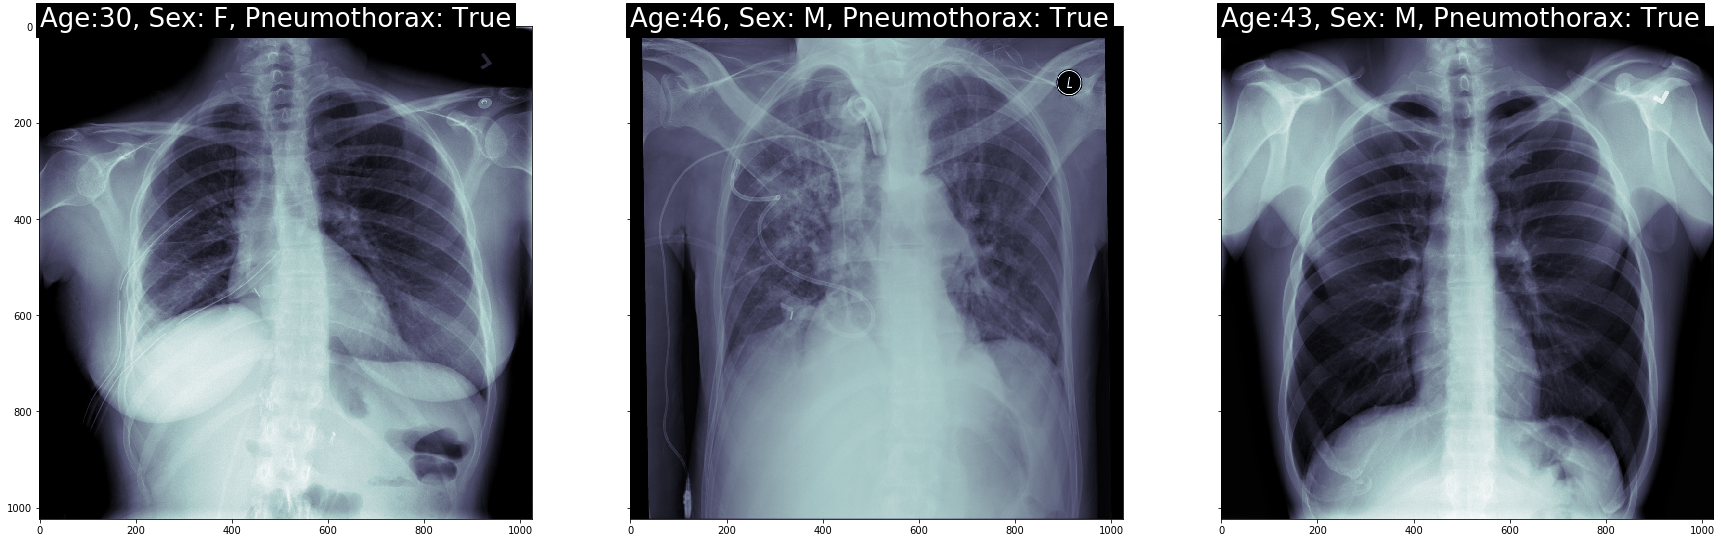

In [11]:
num_img = 3
subplot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for index, row in train_metadata_df.sample(n=num_img).iterrows():
    dataset = pydicom.dcmread(row['file_path'])
    ax[subplot_count].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    # label the x-ray with information about the patient
    ax[subplot_count].text(0,0,'Age:{}, Sex: {}, Pneumothorax: {}'.format(row['patient_age'],row['patient_sex'],row['has_pneumothorax']),
                           size=26,color='white', backgroundcolor='black')
    subplot_count += 1

In [28]:
train_data = np.zeros((42*5,1024*1024+1))
i = 0
j = 0
for index, row in train_metadata_df.sample(n=12089).iterrows():
    dataset = pydicom.dcmread(row['file_path'])
    #print(dataset.pixel_array.shape)

    if row['has_pneumothorax'] == True and i <= 42*4:
        train_data[i,0] = 0
        train_data[i,1:] = dataset.pixel_array.reshape(-1)
    if row['has_pneumothorax'] == False:
        train_data[j+42*4,0] = 1
        train_data[j+42*4,1:] = dataset.pixel_array.reshape(-1)
        j += 1
    i += 1
    


In [22]:
data = np.zeros((42*5,1024*1024+1))